# Training a VAE in the car-race environment

In [4]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
from tqdm import tnrange

/Users/nicom/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset generation
Perform a rollout of N=1000 games with a random policy

In [2]:
env = gym.make('CarRacing-v0')
env.seed(42)

dataset = []

obs = env.reset()
for i in tnrange(10):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        env.reset()
    dataset.append(obs / 255)
np.random.shuffle(dataset)
env.close()
print("Generated", len(dataset),"samples.")

[2018-05-16 18:42:05,035] Making new env: CarRacing-v0


Track generation: 1208..1514 -> 306-tiles track


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Generated 10 samples.


(80, 80, 3)


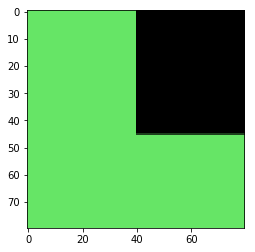

In [6]:
print(dataset[-1].shape)
plt.imshow(dataset[-1][:84])
plt.show()

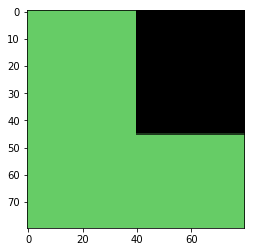

In [6]:
import cv2

img = dataset[-1][:84]
img = cv2.resize(img, dsize=(80, 80))
plt.imshow(img)
plt.show()

## Training
Now, using the dataset we have created, we want to train a VAE

In [7]:
import pickle

In [8]:
dataset = pickle.load(open('car_dataset.pkl','rb'))
print("Dataset with", len(dataset), "samples.")

Dataset with 1000 samples.


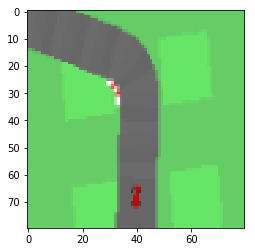

(80, 80, 3)


In [9]:
plt.imshow(dataset[0])
plt.show()
print(dataset[0].shape)

In [20]:
BATCH_SIZE = 32
LATENT_SIZE = 32
LEARNING_RATE = 0.0005

tf.reset_default_graph()

# Input image
X = tf.placeholder(dtype=tf.float32, shape=(None, 80, 80, 3))
# Dropout keep proba
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')
learning_rate = tf.placeholder(dtype=tf.float32, shape=(), name='learning_rate')
batch_size = tf.placeholder(dtype=tf.int32, shape=(), name='batch_size')

# ENCODER GRAPH
with tf.variable_scope("encoder", reuse=None):
    conv1 = tf.layers.conv2d(X, filters=32, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    drop1 = tf.nn.dropout(conv1, keep_prob)
    conv2 = tf.layers.conv2d(drop1, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    drop2 = tf.nn.dropout(conv2, keep_prob)
    conv3 = tf.layers.conv2d(drop2, filters=128, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    drop3 = tf.nn.dropout(conv3, keep_prob)
    conv4 = tf.layers.conv2d(drop3, filters=256, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    drop4 = tf.nn.dropout(conv4, keep_prob)
    flat = tf.layers.flatten(drop4)
    latent_means = tf.layers.dense(flat, units=LATENT_SIZE)
    latent_std = tf.layers.dense(flat, units=LATENT_SIZE)
    latent_noise = tf.random_normal(shape=(batch_size, LATENT_SIZE))
    latent_vector = latent_means + tf.multiply(latent_std, latent_noise)

# DECODER GRAPH
with tf.variable_scope("decoder", reuse=None):
    deflat = tf.layers.dense(latent_vector, units=flat.shape[1])
    deflat4d = tf.reshape(deflat, shape=(-1, drop4.shape[1], drop4.shape[2], drop4.shape[3]))
    deconv1 = tf.layers.conv2d_transpose(deflat4d, filters=128, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    dedrop1 = tf.nn.dropout(deconv1, keep_prob)
    deconv2 = tf.layers.conv2d_transpose(dedrop1, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    dedrop2 = tf.nn.dropout(deconv2, keep_prob)
    deconv3 = tf.layers.conv2d_transpose(dedrop2, filters=32, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    dedrop3 = tf.nn.dropout(deconv3, keep_prob)
    deconv4 = tf.layers.conv2d_transpose(dedrop3, filters=3, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    dedrop4 = tf.nn.dropout(deconv4, keep_prob)
    rebuild = tf.reshape(dedrop4, shape=(-1, 80, 80, 3))
    
# Loss
reconstruction_loss = tf.reduce_sum(tf.squared_difference(rebuild, X))
reg_loss = tf.reduce_sum(-tf.log(tf.abs(latent_std)) + 0.5 * (tf.square(latent_std) + tf.square(latent_means) - 1))
complete_loss = reconstruction_loss + reg_loss

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(complete_loss)

# Session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

(?, 40, 40, 32) (?, 20, 20, 64) (?, 10, 10, 128) (?, 5, 5, 256) (?, 6400)
(?, 5, 5, 256) (?, 10, 10, 128) (?, 20, 20, 64) (?, 40, 40, 32) (?, 80, 80, 3)
